# Importing Important libraries

In [97]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [3]:
meta_data = pd.read_csv("/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv")
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
print("Unique Cancer types represented in data.")
print(meta_data.dx.unique(),"\n")

# Handling categorical data
encoder = LabelEncoder()
meta_data["dx_label"] = encoder.fit_transform(meta_data["dx"])

# Display of labels and their integer encoding
print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Unique Cancer types represented in data.
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 

Cancer types and their integer encoding
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


In [5]:
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


# Data sorting, visualization & augmentation.

## Data sorting

In [6]:
# Sorting images into appropriate directories in order
# to fascilitate real-time data augmentation while training.

# Using the cancer type label for directory creation.
dir_names = encoder.transform(encoder.classes_)

# Data Sorting process.
images_dir = r"/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer"
train_images_dir = r"/kaggle/working/train/"


def create_dirs(dir_path:str, dir_names:list):
    """
    This function creates directories within specified directory path
    with the provided list of directory names.
    
    Inputs
        dir_path:str - The path to which the new directories will reside in.
        dir_names:list - List name(s) of directories to be created.
    """
    # Looping through to create directories in new location.
    for dir_name in dir_names:
        try:
            os.makedirs(os.path.join(dir_path, str(dir_name)))
        except FileExistsError:
            continue

            
# Creating new directories. 
create_dirs(train_images_dir, dir_names)

# Looping through each image in previous folder and
# assigning them to the appropriate folder
for image in os.scandir(images_dir):
    try:
        # attempting to rename image (moving to new dir).
        img_name = image.name.split(".")[0]
        img_cancer_type = str(meta_data.dx_label[meta_data.image_id == img_name].item()) # Retrieving the dx_label for image.
        shutil.copy(os.path.join(images_dir, image.name), os.path.join(train_images_dir, img_cancer_type, image.name))
    except Exception as e:
        print(e)

In [7]:
# ==========================================================================================#
# DO NOT RE-RUN THIS CELL MULTIPLE TIMES IF VALIDATION DIRECTORY HAS ALREADY BEEN POPULATED #
# ==========================================================================================#

validation_images_dir = r"/kaggle/working/validation/"
inds = [] # list to contain directory names of each image.
five_percent_content = {} # Dictionary containing cancer type and the value that is 5% of total number of that type of cancer images.

# Finding out how many images of each cancer type exist
for dir_name in os.scandir(train_images_dir): # Iterating over all train images folders.
    for cancer_img in os.scandir(dir_name): # Iterating over all images in all folders.
        inds.append(cancer_img.path.split("/")[4]) # Appending each images directro number to inds for counting & sorting purpose.
        

# Calculating number of specific type images &
# Calculating what 5% of each image type will be.
for directory in dir_names:
    total_amt = inds.count(str(directory))
    c_type = encoder.inverse_transform([int(directory)])[0]
    print(f"There are {total_amt} images of {c_type} cancer.")
    print(f"5% of {c_type} cancer images is: {round(total_amt * 0.05, 0)}\n")
    five_percent_content[str(directory)] = round(total_amt * 0.05, 0)


# Creating and populating validation set directory
create_dirs(validation_images_dir, dir_names)


# Moving 5% of each type into its respective validation folder.
# Looping through each sub directory
for sub_dir in os.scandir(train_images_dir):
    # Getting all images in current subdir
    images_paths = [image.path for image in os.scandir(sub_dir)]
    # Extracting 5% of images from each directory.
    for image_path in images_paths[: int(five_percent_content[str(sub_dir.name)])]:
        # Getting category for individual images
        image_category = image_path.split("/")[4]
        # creating new image path and moving old image to new destination.
        shutil.move(image_path, os.path.join(validation_images_dir, image_category, image_path.split("/")[-1]))
# ==========================================================================================#
# DO NOT RE-RUN THIS CELL MULTIPLE TIMES IF VALIDATION DIRECTORY HAS ALREADY BEEN POPULATED #
# ==========================================================================================#

There are 327 images of akiec cancer.
5% of akiec cancer images is: 16.0

There are 514 images of bcc cancer.
5% of bcc cancer images is: 26.0

There are 1099 images of bkl cancer.
5% of bkl cancer images is: 55.0

There are 115 images of df cancer.
5% of df cancer images is: 6.0

There are 1113 images of mel cancer.
5% of mel cancer images is: 56.0

There are 6705 images of nv cancer.
5% of nv cancer images is: 335.0

There are 142 images of vasc cancer.
5% of vasc cancer images is: 7.0



## Data visualization

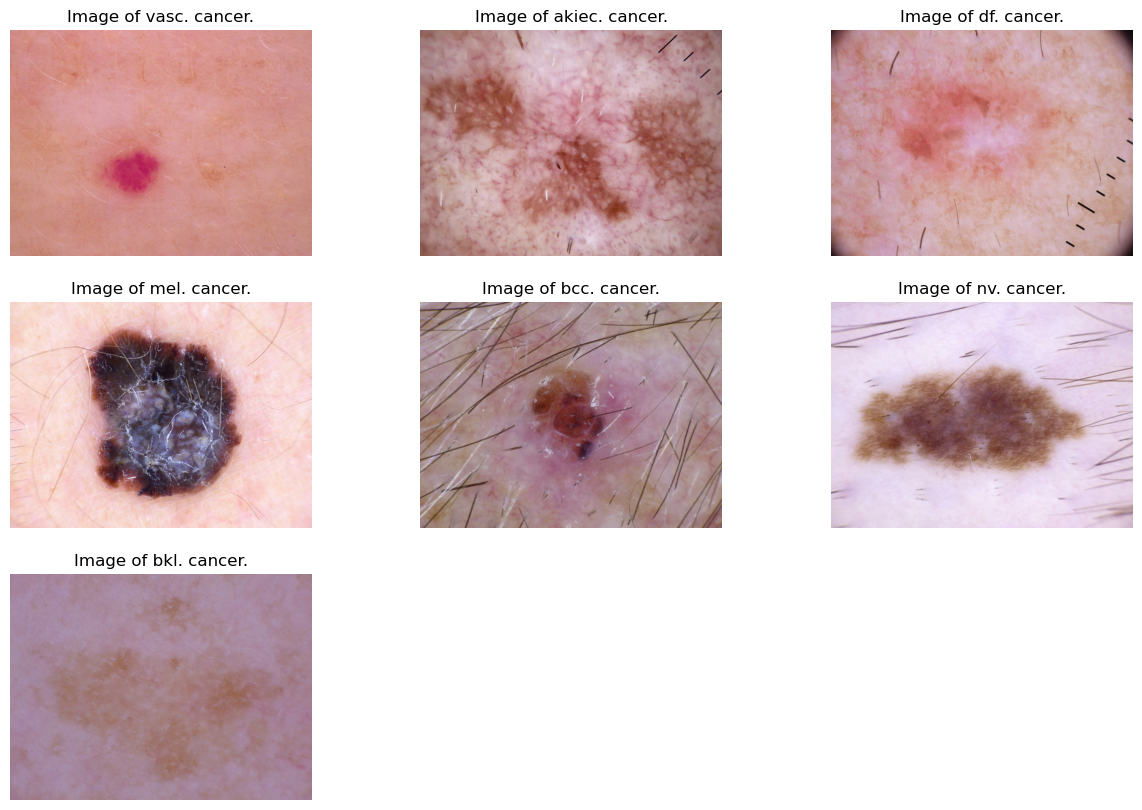

In [8]:
top_n = 20 # Variable for top-n random images to select from.
image_sample = [] # List containing array of images.
image_sample_category = [] # List containing image type

for sub_dir in os.scandir(train_images_dir):
    # Getting all images in current subdir
    images_paths = [image.path for image in os.scandir(sub_dir)]
    current_dir_img_paths = [] # List of top n images from current sub-dir.
    # Extracting random image from each directory.
    for image_path in images_paths[:top_n]:
        current_dir_img_paths.append(image_path) # Appending images from current sub-dir to orary list
        image = random.choice(current_dir_img_paths) # Selecting random image from current images.
        image = cv2.imread(image)[:,:,::-1] # Reading in image and arranging colors.
    image_sample_category.append((encoder.inverse_transform([int(image_path.split("/")[4])])[0])) # Appending image category name to array.
    image_sample.append(image) # Appending image array to list.
        

plt.figure(figsize = (15,10))
for num in range(0, len(image_sample)):
    plt.subplot(3, 3 ,num + 1)
    plt.axis(False)
    plt.title(f"Image of {image_sample_category[num]}. cancer.")
    plt.imshow(image_sample[num]);

## Data augmentation

In [19]:
img_size = 250 # Augmented image size.
batch_size = 32

generator = ImageDataGenerator(zoom_range = 0.3,
                               rotation_range = 90,
                               horizontal_flip = True,
                               vertical_flip = True,
                               validation_split = 0.1,)

# Augmented training set
augmented_train_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = batch_size,
                            subset = "training")

# Un-augmented test set
unaugmented_test_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = 32,
                            subset = "validation")

# Un-augmented dev set.
unaugmented_dev_data = image_dataset_from_directory(
                            validation_images_dir,
                            image_size = (img_size, img_size),
                            batch_size = batch_size)

Found 8566 images belonging to 7 classes.
Found 948 images belonging to 7 classes.
Found 501 files belonging to 7 classes.


# Model training, evaluation.

## Model training.

In [12]:
# Defining model architecture
model = Sequential()

# Layer one
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = (3,3), input_shape= (250, 250, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

# Layer two
model.add(Conv2D(32, kernel_size = (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

# Layer three
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

# # Dropout
# model.add(Dropout(0.5))

# Layer four
model.add(Flatten())
model.add(Dense(32))
model.add(Activation("relu"))

# Layer five
model.add(Dense(7))
model.add(Activation("softmax"))


model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"],
)

# model.summary()
# fitting/training model
history = model.fit_generator(augmented_train_data, validation_data = unaugmented_test_data, epochs = 15, verbose = 1)

Epoch 1/15
268/268 [==============================] - 210s 776ms/step - loss: 0.9937 - accuracy: 0.6681 - val_loss: 0.8479 - val_accuracy: 0.6888
Epoch 2/15
268/268 [==============================] - 206s 769ms/step - loss: 0.8867 - accuracy: 0.6862 - val_loss: 0.8197 - val_accuracy: 0.7015
Epoch 3/15
268/268 [==============================] - 209s 778ms/step - loss: 0.8695 - accuracy: 0.6878 - val_loss: 0.8235 - val_accuracy: 0.7036
Epoch 4/15
268/268 [==============================] - 207s 774ms/step - loss: 0.8451 - accuracy: 0.6916 - val_loss: 0.7547 - val_accuracy: 0.7205
Epoch 5/15
268/268 [==============================] - 208s 778ms/step - loss: 0.8187 - accuracy: 0.7025 - val_loss: 0.7445 - val_accuracy: 0.7247
Epoch 6/15
268/268 [==============================] - 206s 769ms/step - loss: 0.8230 - accuracy: 0.7021 - val_loss: 0.7455 - val_accuracy: 0.7205
Epoch 7/15
268/268 [==============================] - 208s 776ms/step - loss: 0.7933 - accuracy: 0.7073 - val_loss: 0.7360 -

## Model Evaluation

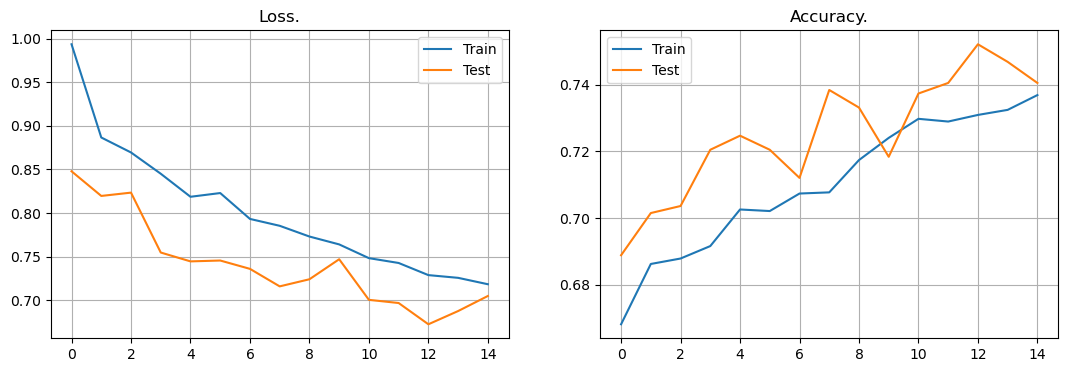

In [13]:
# Extracting metrics
metrics = history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

test_loss = metrics["val_loss"]
test_accuracy = metrics["val_accuracy"]

# Visualizing metrics
plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train");
plt.plot(test_loss, label = "Test");
plt.grid(True)
plt.legend(loc = "best");

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train");
plt.plot(test_accuracy, label = "Test");
plt.grid(True)
plt.legend(loc = "best");

In [22]:
result = model.predict(unaugmented_dev_data)

16/16 [==============================] - 3s 95ms/step


In [98]:
true_class = [] # List containing true labels for each image.
predicted_class = [predicted_label.argmax() for predicted_label in result]

for file_path in unaugmented_dev_data.file_paths: # Looping through each image file path in dev set
    true_class.append(int(file_path.split("/")[4])) # Appending the image folder name/cancer type label to list

# Understanding classification power of model on each class    
report = classification_report(true_class, predicted_class)
print(report)

              precision    recall  f1-score   support

           0       0.07      0.06      0.06        16
           1       0.08      0.08      0.08        26
           2       0.10      0.07      0.08        55
           3       0.00      0.00      0.00         6
           4       0.10      0.14      0.11        56
           5       0.68      0.68      0.68       335
           6       0.00      0.00      0.00         7

    accuracy                           0.49       501
   macro avg       0.15      0.15      0.15       501
weighted avg       0.49      0.49      0.48       501



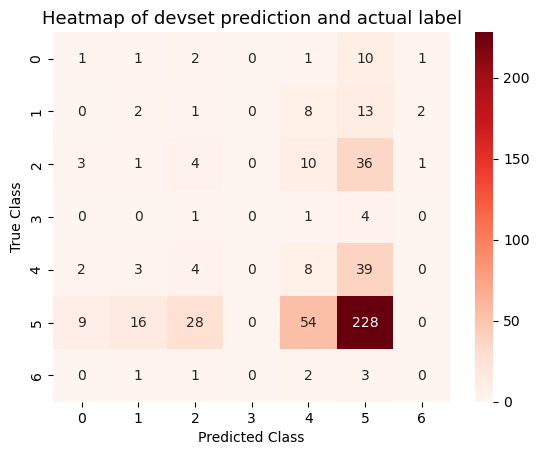

In [100]:
# Investigating F1 score.    
# Calculating confusion matrix
plt.title("Heatmap of devset prediction and actual label", fontsize = 13)
cm = confusion_matrix(true_class, predicted_class)
sns.heatmap(cm, cmap = "Reds", annot = True, fmt = "d");
plt.ylabel("True Class");
plt.xlabel("Predicted Class");